# 对各个国家按照获得奖牌数和获得奖牌的稳定性进行分类

##　加载数据

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
%cd dataset
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/dataset
country.csv		       noc_codes.json		     robust_scaler.pkl
country_medal_probability.csv  olympic_medals_2000-2020.csv  scatter_matrix.png
country_olympic_potential.csv  olympic_medals_with_noc.csv   score_validation.png
data_dictionary.csv	       olympic_score_model.pkl	     summerOly_athletes.csv
final_medal_table.csv	       potential_stars.csv	     summerOly_hosts.csv
medal_distribution.png	       potential_stars_filtered.csv  summerOly_medal_counts.csv
merged_country_data.csv        residual_plot.png	     summerOly_programs.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
athletes = pd.read_csv('summerOly_athletes.csv')
hosts = pd.read_csv('summerOly_hosts.csv')
medal_counts = pd.read_csv('summerOly_medal_counts.csv')
programs = pd.read_csv('summerOly_programs.csv',encoding='latin-1')
countrys = pd.read_csv('country.csv')

In [15]:
medal_counts.info()
medal_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    1435 non-null   int64 
 1   NOC     1435 non-null   object
 2   Gold    1435 non-null   int64 
 3   Silver  1435 non-null   int64 
 4   Bronze  1435 non-null   int64 
 5   Total   1435 non-null   int64 
 6   Year    1435 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 78.6+ KB


,Rank,NOC,Gold,Silver,Bronze,Total,Year
0,1,United States,11,7,2,20,1896
1,2,Greece,10,18,19,47,1896
2,3,Germany,6,5,2,13,1896
3,4,France,5,4,2,11,1896
4,5,Great Britain,2,3,2,7,1896
...,...,...,...,...,...,...,...
1430,84,Qatar,0,0,1,1,2024
1431,84,Refugee Olympic Team,0,0,1,1,2024
1432,84,Singapore,0,0,1,1,2024
1433,84,Slovakia,0,0,1,1,2024


In [16]:
# 假设原始数据存储在变量df中
df = medal_counts.copy()
# 按国家统计各奖牌的总和
sum_df = df.groupby('NOC').agg(
    Gold_sum=('Gold', 'sum'),
    Silver_sum=('Silver', 'sum'),
    Bronze_sum=('Bronze', 'sum'),
    Total_sum=('Total', 'sum')
).reset_index()

# 按国家计算每年总奖牌数的方差
variance_df = df.groupby('NOC')['Total'].var().reset_index(name='Variance')

# 合并总和数据和方差数据
result = pd.merge(sum_df, variance_df, on='NOC')

# 保存结果到CSV文件
result.to_csv('country_medal_stats.csv', index=False)

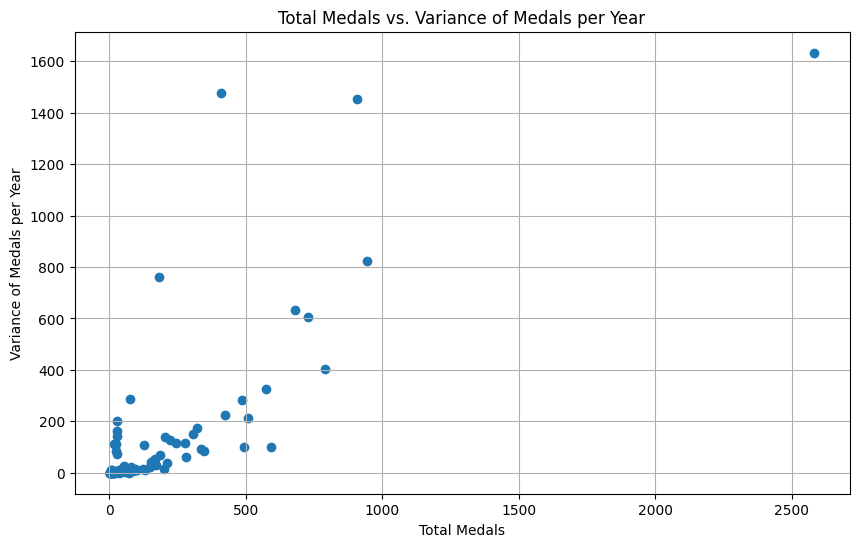

In [18]:
# 将result按照Total_sum列和Variance分别作为横纵坐标作图

import matplotlib.pyplot as plt

# Assuming 'result' DataFrame is already created as in the previous code

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(result['Total_sum'], result['Variance'])
plt.xlabel('Total Medals')
plt.ylabel('Variance of Medals per Year')
plt.title('Total Medals vs. Variance of Medals per Year')
plt.grid(True)
plt.show()

In [19]:
# 计算中位数
total_median = result['Total_sum'].median()
variance_median = result['Variance'].median()

# 处理可能的NaN方差（如单年数据导致方差为NaN）
result['Variance'] = result['Variance'].fillna(variance_median)  # 将NaN视为中等方差

# 分类函数
def classify(row):
    if row['Total_sum'] >= total_median and row['Variance'] <= variance_median:
        return '奖牌多且稳定'
    elif row['Total_sum'] < total_median and row['Variance'] <= variance_median:
        return '奖牌少但稳定'
    elif row['Total_sum'] >= total_median and row['Variance'] > variance_median:
        return '奖牌多但不稳定'
    else:
        return '奖牌少且不稳定'

# 添加分类列
result['Category'] = result.apply(classify, axis=1)

# 保存结果到新文件
result.to_csv('classified_country_medal_stats.csv', index=False)

# 显示分类统计
print(result['Category'].value_counts())

Category
奖牌少但稳定     100
奖牌多但不稳定     72
奖牌多且稳定      35
奖牌少且不稳定      3
Name: count, dtype: int64
